In [1]:
import numpy  as np
import pandas as pd

import seaborn           as sns
import matplotlib.pyplot as plt

import json, calendar

from urllib.request import urlopen
from bs4 import BeautifulSoup

In [2]:
# url = 'http://www.kaggle.com/awater1223'
# html  = urlopen(url)
# bsObj = BeautifulSoup(html,'lxml')
# table = bsObj.find("div", {"class":"site-layout__main-content"})

url = 'http://www.kaggle.com/awater1223/activity.json'

html = urlopen(url)
text = html.read().decode('utf-8')
data = json.loads(text)
df = pd.DataFrame(data)
df.to_csv('KaggleActivity_'+pd.Timestamp.today().strftime('%Y%m%d')+'.csv')

In [3]:
df_date = pd.to_datetime(df['date'])

start = (
    pd.Timestamp.today() 
    - pd.Timedelta(value=pd.Timestamp.today().dayofweek,unit='D') # week start
    - pd.Timedelta(value=52,unit='W')
    - pd.Timedelta(days=1)
)
end = pd.Timestamp.today() - pd.Timedelta(value=pd.Timestamp.today().dayofweek,unit='D') + pd.Timedelta(days=7-1-1)

df_matrix = pd.concat(
    [
        df_date.apply(lambda row: row.date).rename('date'),
        df_date.apply(lambda row: row.year).rename('y'),
        df_date.apply(lambda row: (row.date() - start.date()).days//7).rename('n_w'),
#         df_date.apply(lambda row: (row+pd.Timedelta(days=1)).weekofyear).rename('n_w'),
        df_date.apply(lambda row: (row+pd.Timedelta(days=1)).dayofweek).rename('n_d'),
        df_date.apply(lambda row: calendar.month_abbr[row.month]).rename('m_n'),
        df.drop('date',axis=1).sum(axis=1).rename('act'),
    ], axis=1
).set_index('date')


for dt in pd.date_range(start=start,end=end):
    idx = dt.date()
    if idx in df_matrix.index:
        continue
    else:
        df_matrix.loc[idx] = {
            'y':idx.year,
            'n_w':(idx - start.date()).days//7,
            'n_d':(dt+pd.Timedelta(days=1)).dayofweek,
            'm_n':calendar.month_abbr[dt.month],
            'act':0,
        }

df_matrix = df_matrix.sort_index()        

heatmap = np.zeros((52,7),dtype=int)

for _,row in df_matrix.iterrows():
    n_w = row['n_w']-1
    n_d = row['n_d']
    n_a = row['act']
    heatmap[n_w,n_d] = n_a


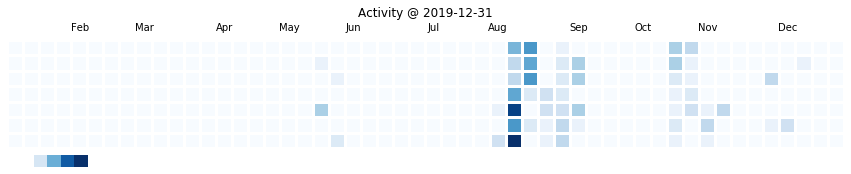

In [4]:
month_dict = df_matrix.drop_duplicates(subset=['y','m_n'],keep='first')
month_dict = dict(zip( month_dict['n_w'].values, month_dict['m_n'].values ))
month_idx = pd.Series( np.arange(0,52)+1 ).replace(month_dict).replace(dict(zip(np.arange(0,52)+1,['']*52))).tolist()[:-1]
month_idx = ['']+month_idx

fig, ax = plt.subplots(figsize=(15,2))
cbar_ax = fig.add_axes([0.15, 0.0, 0.05, 0.08]) # [left, bottom, width, height]

g = sns.heatmap(
    heatmap.T, 
    vmax=15, 
    cmap='Blues',
    xticklabels=month_idx,
    yticklabels=False,
    linewidths=2,
    cbar_kws={ 
        'ticks':[], 
        'boundaries' : np.arange(0,25,5),
        'orientation':'horizontal',
    },
    cbar_ax = cbar_ax,
    ax = ax
)
cbar_ax.get_xaxis().set_ticklabels([]);

ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

ax.set_title('Activity @ '+pd.Timestamp.today().strftime('%Y-%m-%d'))
ax.tick_params(top=False)

fig.savefig('Kaggle_Activity_' + pd.Timestamp.today().strftime('%Y') + '.png', bbox_inches='tight')
fig.savefig('Kaggle_Activity_' + pd.Timestamp.today().strftime('%Y') + '.svg', bbox_inches='tight')
